Cost after epoch 0: 0.6409768761516396
Cost after epoch 5: 0.3963762292063719
Cost after epoch 10: 0.37140508532160776
Cost after epoch 15: 0.3544568459823229
Cost after epoch 20: 0.3491928129191921
Cost after epoch 25: 0.33973839524316596


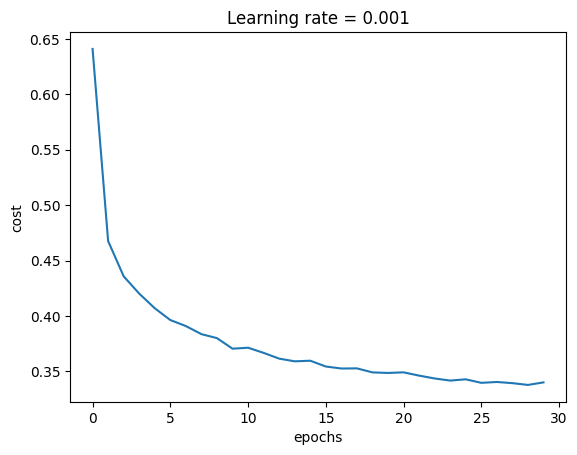

Train Accuracy:
Accuracy: 91.78%

Test Accuracy:
Accuracy: 88.58%


In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

def load_and_prepare_data():
    (train_x_orig, train_y_orig), (test_x_orig, test_y_orig) = fashion_mnist.load_data()
    train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
    test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
    train_x = train_x_flatten / 255.
    test_x = test_x_flatten / 255.
    train_y = one_hot_encoder(train_y_orig, 10)
    test_y = one_hot_encoder(test_y_orig, 10)
    return train_x, train_y, test_x, test_y

def one_hot_encoder(Y, C):
    Y_squeezed = np.squeeze(Y)
    Y_one_hot = np.eye(C)[Y_squeezed].T
    return Y_one_hot


def relu(Z):
    A = np.maximum(0, Z)
    return A, Z

def softmax(Z):
    t = np.exp(Z - np.max(Z, axis=0))
    A = t / np.sum(t, axis=0, keepdims=True)
    return A, Z

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ


def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * np.sqrt(2 / layer_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters


def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    return Z, (A, W, b)

def linear_activation_forward(A_prev, W, b, activation, keep_prob=1.0):
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)

    # Dropout implementation
    D = None
    if keep_prob < 1.0:
        D = np.random.rand(A.shape[0], A.shape[1]) < keep_prob
        A = A * D
        A = A / keep_prob

    cache = (linear_cache, activation_cache, D)
    return A, cache

def L_model_forward(X, parameters, keep_prob=1.0):
    caches = []
    A = X
    L = len(parameters) // 2

    # Hidden layers with dropout
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu", keep_prob)
        caches.append(cache)

    # Output layer without dropout
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "softmax", 1.0)
    caches.append(cache)

    return AL, caches


def compute_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    L = len(parameters) // 2
    cross_entropy_cost = -1/m * np.sum(Y * np.log(AL + 1e-8))

    L2_regularization_cost = 0
    for l in range(1, L + 1):
        W = parameters['W' + str(l)]
        L2_regularization_cost += np.sum(np.square(W))

    L2_regularization_cost = (lambd / (2 * m)) * L2_regularization_cost
    return cross_entropy_cost + L2_regularization_cost

# with Dropout and L2

def linear_backward_with_regularization(dZ, cache, lambd):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1./m) * np.dot(dZ, A_prev.T) + (lambd / m) * W
    db = (1./m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation, lambd):
    linear_cache, activation_cache, D = cache

    # Dropout backward pass
    if D is not None:
        dA = dA * D
        dA = dA / np.mean(D)

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward_with_regularization(dZ, linear_cache, lambd)
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches, lambd, keep_prob=1.0):
    grads = {}
    L = len(caches)

    dZL = AL - Y
    current_cache = caches[L-1]
    linear_cache, _, _ = current_cache
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward_with_regularization(dZL, linear_cache, lambd)

    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        # Pass keep_prob to the relu layers
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu", lambd)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


def initialize_adam(parameters):
    L = len(parameters) // 2
    v = {}
    s = {}
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros(parameters["W" + str(l + 1)].shape)
        v["db" + str(l + 1)] = np.zeros(parameters["b" + str(l + 1)].shape)
        s["dW" + str(l + 1)] = np.zeros(parameters["W" + str(l + 1)].shape)
        s["db" + str(l + 1)] = np.zeros(parameters["b" + str(l + 1)].shape)
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01,
                                beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len(parameters) // 2
    v_corrected, s_corrected = {}, {}

    for l in range(L):
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - beta1 ** t)
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - beta1 ** t)

        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.square(grads['dW' + str(l + 1)])
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.square(grads['db' + str(l + 1)])
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - beta2 ** t)
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - beta2 ** t)

        parameters["W" + str(l + 1)] -= learning_rate * v_corrected["dW" + str(l + 1)] / (np.sqrt(s_corrected["dW" + str(l + 1)]) + epsilon)
        parameters["b" + str(l + 1)] -= learning_rate * v_corrected["db" + str(l + 1)] / (np.sqrt(s_corrected["db" + str(l + 1)]) + epsilon)

    return parameters, v, s

# Mini-batch gradient descent

def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0], m))

    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batches.append((mini_batch_X, mini_batch_Y))

    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size:]
        mini_batches.append((mini_batch_X, mini_batch_Y))

    return mini_batches


def L_layer_model(X, Y, layers_dims, learning_rate=0.001, num_epochs=30,
                    print_cost=True, mini_batch_size=64, lambd=0.0, keep_prob=1.0):
    np.random.seed(1)
    costs = []
    seed, t = 10, 0
    m = X.shape[1]

    parameters = initialize_parameters_deep(layers_dims)
    v, s = initialize_adam(parameters)

    for i in range(num_epochs):
        seed += 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        epoch_cost = 0

        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            AL, caches = L_model_forward(minibatch_X, parameters, keep_prob)
            cost = compute_cost(AL, minibatch_Y, parameters, lambd)
            epoch_cost += cost
            grads = L_model_backward(AL, minibatch_Y, caches, lambd)
            t += 1
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate)

        avg_cost = epoch_cost / (m / mini_batch_size)
        if print_cost and i % 5 == 0:
            print(f"Cost after epoch {i}: {avg_cost}")
        if print_cost:
            costs.append(avg_cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('epochs')
    plt.title(f"Learning rate = {learning_rate}")
    plt.show()

    return parameters


def predict(X, y, parameters):
    m = X.shape[1]
    p = np.zeros((1, m), dtype=int)
    # Forward pass with keep_prob=1.0 (no dropout) for prediction
    probas, _ = L_model_forward(X, parameters, keep_prob=1.0)

    for i in range(probas.shape[1]):
        p[0, i] = np.argmax(probas[:, i])

    y_indices = np.argmax(y, axis=0)
    accuracy = np.mean(p[0, :] == y_indices) * 100
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy, p


if __name__ == '__main__':
    train_x, train_y, test_x, test_y = load_and_prepare_data()

    # Hyperparameters
    layers_dims = [784, 128, 64, 10]
    learning_rate = 0.001
    num_epochs = 30
    mini_batch_size = 64
    lambd = 0.01  # L2 regularization
    keep_prob = 0.8 # Dropout keep probability

    parameters = L_layer_model(train_x, train_y, layers_dims,
                               learning_rate=learning_rate,
                               num_epochs=num_epochs,
                               mini_batch_size=mini_batch_size,
                               lambd=lambd,
                               keep_prob=keep_prob,
                               print_cost=True)

    print("Train Accuracy:")
    train_accuracy, _ = predict(train_x, train_y, parameters)

    print("\nTest Accuracy:")
    test_accuracy, _ = predict(test_x, test_y, parameters)